In [ ]:
!pip install nltk
!pip install spacy
!python -m spacy download es_core_news_sm
!pip install -U imbalanced-learn
!pip install pyspellchecker


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Oculta warnings
import warnings
warnings.simplefilter('ignore')

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# CARGAR DATOS
**DATOS DE ENTRENAMIENTO**

la columna de trastornos indica si el TWEET es de una persona con depresión o es de control.


**control**:     0

**depresión**:   1

#DATOS DE PRUEBA

In [ ]:
ruta_archivo_entrenamiento = '/content/drive/MyDrive/Experimentación Python Tesis /entrenamiento y prueba (control vs depresión)/train.csv'
data_train = pd.read_csv(ruta_archivo_entrenamiento, sep=',')
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263950 entries, 0 to 263949
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   USER_ID     263950 non-null  object 
 1   TWEET_ID    263920 non-null  float64
 2   TWEET_TEXT  263841 non-null  object 
 3   trastorno   263950 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 8.1+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,87,2.147484e+09,RT @Julii_AKD: por qué a la mayoría de las pib...,1
1,6,2.147484e+09,Empezar un 2017 sintiéndote solo.,1
2,279,2.147484e+09,Ah mirá que lindo como me escrachan en Instagr...,0
3,518,2.147484e+09,https://t.co/hC3rULMb1P,0
4,301,2.147484e+09,"Tu sigue con él, cumple tu deber, muy pronto v...",0
5,177,2.147484e+09,@Sebbasrp deje dormir al prójimo.,0
6,45,2.147484e+09,"RT @Crookedgirlx: no quiero vivir más, estoy c...",1
7,29,2.147484e+09,RT @Esunbreakable: Me da un poquito de vergüen...,1
8,388,2.147484e+09,Venezuela-related Designation https://t.co/IOZ...,0
9,31,2.147484e+09,Tengo muchas ganas de escribirte para decirte ...,1


#Preprocesamiento de los datos

*Eliminar etiquetas HTML*

In [ ]:
import re

def removeHTML(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', text)
        return cleantext
    else:
        return text  # Devolver el valor original si no es de tipo string

*Limpieza del texto*

In [ ]:
import re
import string

def clean(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        # Eliminar hashtags
        text = re.sub(r'#\w+', '', text)

        # Eliminar URLs o enlaces
        text = re.sub(r'(https?://)?[a-zA-Z0-9]+\.[a-zA-Z0-9]+\S*', '', text)

        # Eliminar nombres de usuarios de Twitter
        text = re.sub(r'@\w+', '', text)

        # Eliminar Nombres propios
        text = re.sub(r'\b[A-Z][a-z]+\b', '', text)

        # Eliminar todos los caracteres especiales
        text = re.sub(r'[^\w\s]+', '', text)

        # Eliminar prefijos y números
        text = re.sub(r'\b\w{1,2}\b|\d+', '', text)

        # Eliminar palabras específicas
        specific_words = ['retweet', 'retweets', 'hashtag', 'trending', 'mención', 'enlace', 'emoji', 'timeline', 'interacciones',
                          'tuit', 'seguidores', 'notificaciones', 'seguir', 'favorito', 'perfil', 'tendencia', 'influencer',
                          'compartir', 'actualización', 'explorar', 'seguir', 'comunidad', 'contenido', 'popular',
                          'recomendar', 'experiencia', 'conectar', 'comentar', 'compartir', 'comunidad', 'actualización',
                          'drk', 'followers', 'stats', 'for', 'new', 'little', 'unfollower', 'unfollowers', 'today', 'shit','twitter','nombre',
                          'eric','story','great', 'short','squeeze','piggly','wiggly','hmv','even','follas','you','i','he','she',
                          'it','we','they','the','and','that','these','those','tweet','followed','follower']
        text = ' '.join([word for word in text.split() if word not in specific_words])

        # Eliminar emojis
        emojis = re.findall(r'[^\w\s,]', text)
        cleaned_emojis = [emoji for emoji in emojis if emoji not in ['@', '#', '/', '?','¿','.','…','"',':','“','!','¡','°','-',"‘",'’',
                                                                     '=',';','(',')',"'","'",'&','€','%','$','*','+','|', '”','🇦','🇷',',',
                                                                     ', ','—','«',' »','»','« ','[, ]','[,]',',',', ','',' ',' ♀',' 🏽']]
        for emoji in cleaned_emojis:
            text = text.replace(emoji, '')

        # Convertir el texto a minúsculas
        text = text.lower()

        # Eliminar signos de puntuación
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
        # Tokenizar el texto en palabras
        words = text.split()

        # Reconstruir el texto limpio
        text = ' '.join(words)

        # Devuelve el texto limpio
        return text
    else:
        return text  # Devolver el valor original si no es de tipo string

In [ ]:
def Tokenizer(text):
    if isinstance(text, str):
        return text.split()
    else:
        return []  # Si el valor no es una cadena, retornar una lista vacía

# Preprocesamieto del conjunto de datos de entrenamiento

In [ ]:
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(removeHTML)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(clean)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(Tokenizer)
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263950 entries, 0 to 263949
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   USER_ID     263950 non-null  object 
 1   TWEET_ID    263920 non-null  float64
 2   TWEET_TEXT  263950 non-null  object 
 3   trastorno   263950 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 8.1+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,87,2.147484e+09,"[por, qué, mayoría, las, pibas, les, gusta, te...",1
1,6,2.147484e+09,"[sintiéndote, solo]",1
2,279,2.147484e+09,"[mirá, que, lindo, como, escrachan, magnifico]",0
3,518,2.147484e+09,[],0
4,301,2.147484e+09,"[sigue, con, cumple, deber, muy, pronto, vesti...",0
5,177,2.147484e+09,"[deje, dormir, prójimo]",0
6,45,2.147484e+09,"[quiero, vivir, más, estoy, cansada, todo]",1
7,29,2.147484e+09,"[poquito, vergüenza, cuando, alguien, quiere, ...",1
8,388,2.147484e+09,[related],0
9,31,2.147484e+09,"[muchas, ganas, escribirte, para, decirte, que...",1


In [ ]:
# Verificar si hay elementos vacíos en la columna 'TWEET_TEXT'
empty_count = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos en la columna 'TWEET_TEXT'
print("Número de elementos vacíos en la columna 'TWEET_TEXT':", empty_count)

Número de elementos vacíos en la columna 'TWEET_TEXT': 16750


In [ ]:
# Filtrar filas donde 'TWEET_TEXT' no sea una lista vacía
data_train = data_train[data_train['TWEET_TEXT'].apply(len) > 0]

# Reiniciar el índice del DataFrame después de eliminar filas
data_train.reset_index(drop=True, inplace=True)

In [ ]:
# Verificar si hay elementos vacíos en la columna 'TWEET_TEXT'
empty_count = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos en la columna 'TWEET_TEXT'
print("Número de elementos vacíos en la columna 'TWEET_TEXT':", empty_count)

Número de elementos vacíos en la columna 'TWEET_TEXT': 0


#Vectorización de los datos



In [ ]:
import gensim
from gensim.models import Word2Vec
# Entrena un modelo Word2Vec usando CBOW
modelW = Word2Vec(data_train['TWEET_TEXT'], vector_size=300, window=5, min_count=1, sg=0)

# Obtener la representación vectorial de un documento promediando las palabras
def document_vector(tokens, modelW):
    # Filtrar palabras que no están en el modelo
    tokens = [token for token in tokens if token in modelW.wv.key_to_index]
    if len(tokens) == 0:
        return np.zeros(modelW.vector_size)
    return np.mean([modelW.wv[token] for token in tokens], axis=0)

# Crear una matriz de características X utilizando las representaciones vectoriales de Word2Vec
X  = np.array([document_vector(tokens, modelW) for tokens in data_train['TWEET_TEXT']])

# Asegurémonos de que los valores en X_word2vec sean no negativos
X[X  < 0] = 0

# Discretizar los valores en X_word2vec en palabras
X = [[str(i) for i in vector] for vector in X]


# Obtener las etiquetas y
y = data_train['trastorno'].values


In [ ]:
# Imprimimos el la longitud de las palabras totales
print(modelW)
print(len(modelW.wv))
# Observamos el vocabulario creado
words = modelW.wv.index_to_key
print(words)

Word2Vec<vocab=93122, vector_size=300, alpha=0.025>
93122
['que', 'con', 'por', 'las', 'los', 'para', 'una', 'más', 'del', 'como', 'pero', 'todo', 'cuando', 'día', 'ser', 'vida', 'quiero', 'porque', 'estoy', 'bien', 'nada', 'tengo', 'qué', 'tan', 'esta', 'alguien', 'soy', 'todos', 'siempre', 'mal', 'vez', 'sin', 'este', 'así', 'está', 'voy', 'mierda', 'mas', 'nadie', 'estar', 'mejor', 'son', 'solo', 'hay', 'ganas', 'algo', 'cosas', 'hacer', 'nunca', 'mis', 'eso', 'hace', 'nos', 'muy', 'siento', 'persona', 'gente', 'personas', 'puedo', 'veces', 'ver', 'hoy', 'mucho', 'tener', 'tiene', 'sus', 'mundo', 'esa', 'hasta', 'tiempo', 'puede', 'tanto', 'ahora', 'años', 'mañana', 'esto', 'días', 'fotos', 'fue', 'les', 'vos', 'estos', 'amor', 'tus', 'cuenta', 'menos', 'cada', 'llorar', 'pasa', 'vía', 'quien', 'mismo', 'sea', 'feliz', 'vivir', 'verdad', 'dormir', 'uno', 'casa', 'cómo', 'dos', 'momento', 'sólo', 'ese', 'otra', 'también', 'poco', 'año', 'era', 'odio', 'después', 'gusta', 'donde', 'qu

# **divir y reducir la demensionalidad de los datos de entrenamiento**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Aplicar LDA para reducir la dimensionalidad
n_topics = 10  # Define el número de tópicos (componentes)
lda = LDA(n_components=n_topics)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

In [ ]:


# Crear un modelo de Regresión Logística
model = LogisticRegression(random_state=42)

# Entrenar el modelo en los datos de entrenamiento transformados por LDA
model.fit(X_train_lda, y_train)

# Predecir las etiquetas en el conjunto de prueba
y_pred = model.predict(X_test_lda)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud del modelo: {accuracy * 100:.2f}%")

# Calcular la precisión, recall y puntuación F1
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precisión: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"Puntuación F1: {f1 * 100:.2f}%")

Exactitud del modelo: 67.75%
Precisión: 67.97%
Recall: 67.75%
Puntuación F1: 67.70%


# MATRIZ DE CONFUSIÓN

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test_lda)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_test, y_pred_binario)
prop_real = np.sum(y_test)/len(y_test)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_test)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[23868 13750]
 [10163 26379]] 

Proporción de comentarios positivos: 0.49
Proporción de comentarios positivos etiquetados: 0.54


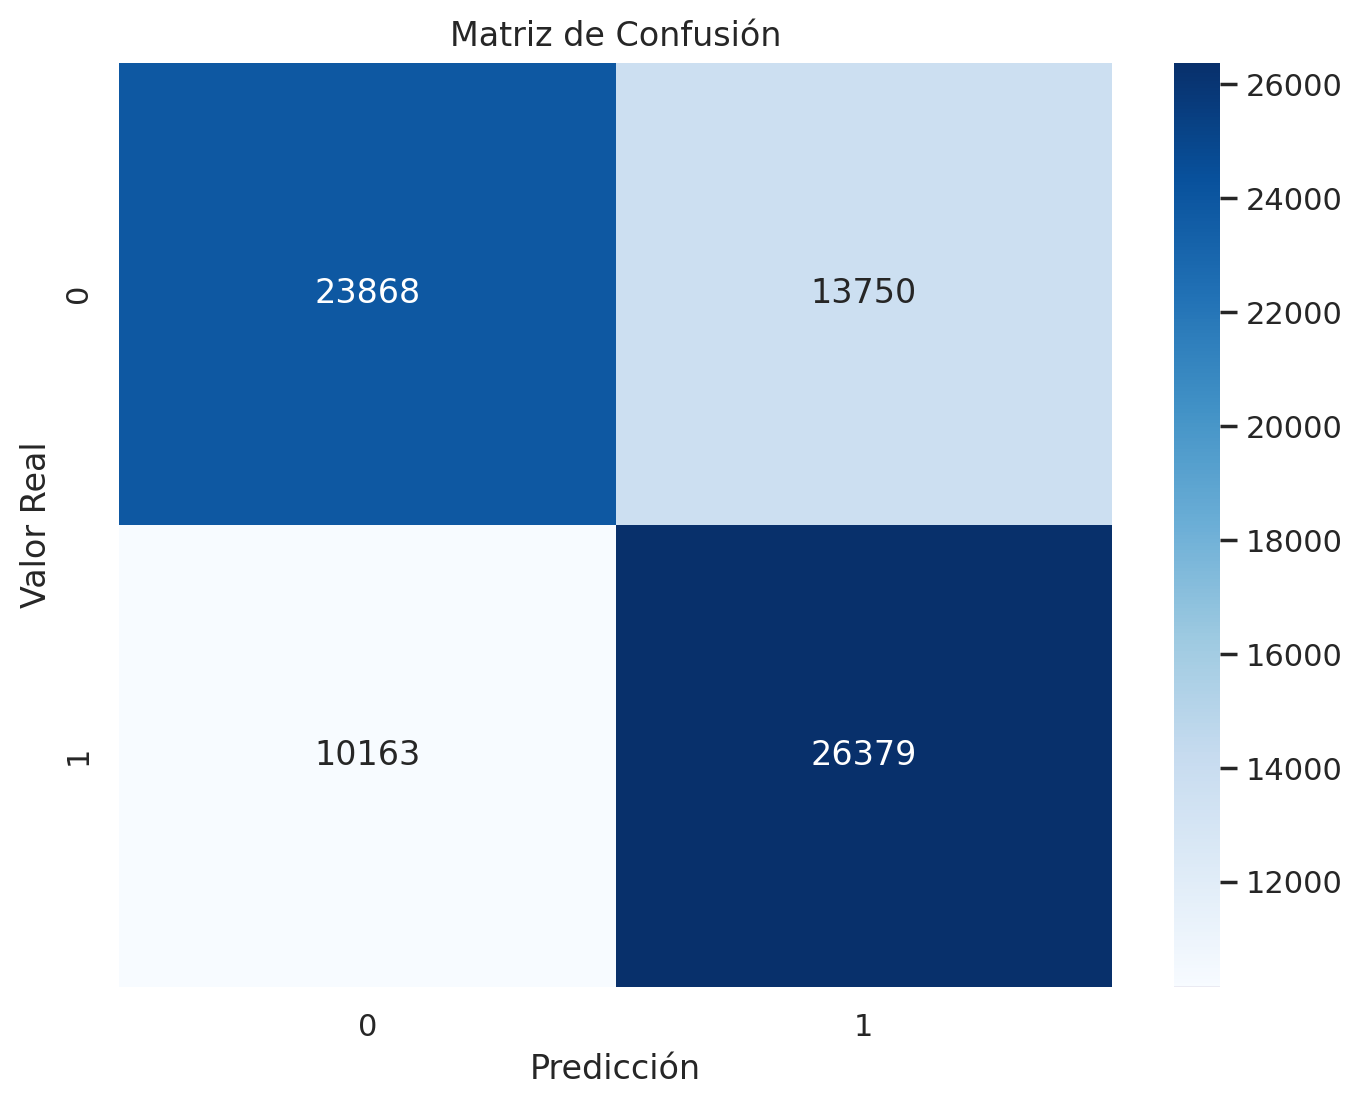

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Mostrar la gráfica
plt.show()

# Aprensizaje del modelo: Regresión Logística
**Validación Cruzada K=10**

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Inicializar listas para almacenar métricas
train_accuracy_scores = []
train_precision_scores = []
train_recall_scores = []
train_f1_scores = []

val_accuracy_scores = []
val_precision_scores = []
val_recall_scores = []
val_f1_scores = []

# Crear un objeto StratifiedKFold para dividir los datos en k-folds estratificados
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


# Dividir los datos en k-folds y realizar la validación cruzada
for train_index, val_index in skf.split(X_train_lda, y_train):
    X_train_fold, X_val_fold = X_train_lda[train_index], X_train_lda[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Crear un modelo de Regresión Logística
    model = LogisticRegression(penalty='l1', C=10, solver='liblinear', random_state=42)
    # Entrenar el modelo en los datos de entrenamiento transformados por LDA
    model.fit(X_train_fold, y_train_fold)

    # Predecir las etiquetas en el conjunto de entrenamiento y validación
    y_train_pred = model.predict(X_train_fold)
    y_val_pred = model.predict(X_val_fold)

    # Calcular métricas de entrenamiento
    train_accuracy = accuracy_score(y_train_fold, y_train_pred)
    train_precision = precision_score(y_train_fold, y_train_pred, average='weighted')
    train_recall = recall_score(y_train_fold, y_train_pred, average='weighted')
    train_f1 = f1_score(y_train_fold, y_train_pred, average='weighted')

    # Calcular métricas de validación
    val_accuracy = accuracy_score(y_val_fold, y_val_pred)
    val_precision = precision_score(y_val_fold, y_val_pred, average='weighted')
    val_recall = recall_score(y_val_fold, y_val_pred, average='weighted')
    val_f1 = f1_score(y_val_fold, y_val_pred, average='weighted')

    # Almacenar las métricas en las listas
    train_accuracy_scores.append(train_accuracy)
    train_precision_scores.append(train_precision)
    train_recall_scores.append(train_recall)
    train_f1_scores.append(train_f1)

    val_accuracy_scores.append(val_accuracy)
    val_precision_scores.append(val_precision)
    val_recall_scores.append(val_recall)
    val_f1_scores.append(val_f1)

# Calcular las métricas promediadas en entrenamiento
train_accuracy_mean = np.mean(train_accuracy_scores)
train_precision_mean = np.mean(train_precision_scores)
train_recall_mean = np.mean(train_recall_scores)
train_f1_mean = np.mean(train_f1_scores)

# Calcular las métricas promediadas en validación
val_accuracy_mean = np.mean(val_accuracy_scores)
val_precision_mean = np.mean(val_precision_scores)
val_recall_mean = np.mean(val_recall_scores)
val_f1_mean = np.mean(val_f1_scores)

# Imprimir las métricas promediadas
print("Métricas de entrenamiento promediadas:")
print(f"Exactitud: {train_accuracy_mean * 100:.2f}%")
print(f"Precisión: {train_precision_mean * 100:.2f}%")
print(f"Recuperación: {train_recall_mean * 100:.2f}%")
print(f"Puntuación F1: {train_f1_mean * 100:.2f}%")

print("\nMétricas de validación promediadas:")
print(f"Exactitud: {val_accuracy_mean * 100:.2f}%")
print(f"Precisión: {val_precision_mean * 100:.2f}%")
print(f"Recuperación: {val_recall_mean * 100:.2f}%")
print(f"Puntuación F1: {val_f1_mean * 100:.2f}%")


Métricas de entrenamiento promediadas:
Exactitud: 67.85%
Precisión: 68.08%
Recuperación: 67.85%
Puntuación F1: 67.80%

Métricas de validación promediadas:
Exactitud: 67.85%
Precisión: 68.07%
Recuperación: 67.85%
Puntuación F1: 67.79%


# MATRIZ DE CONFUSIÓN

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_val_fold)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val_fold, y_pred_binario)
prop_real = np.sum(y_val_fold)/len(y_val_fold)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val_fold)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[5614 3183]
 [2400 6107]] 

Proporción de comentarios positivos: 0.49
Proporción de comentarios positivos etiquetados: 0.54


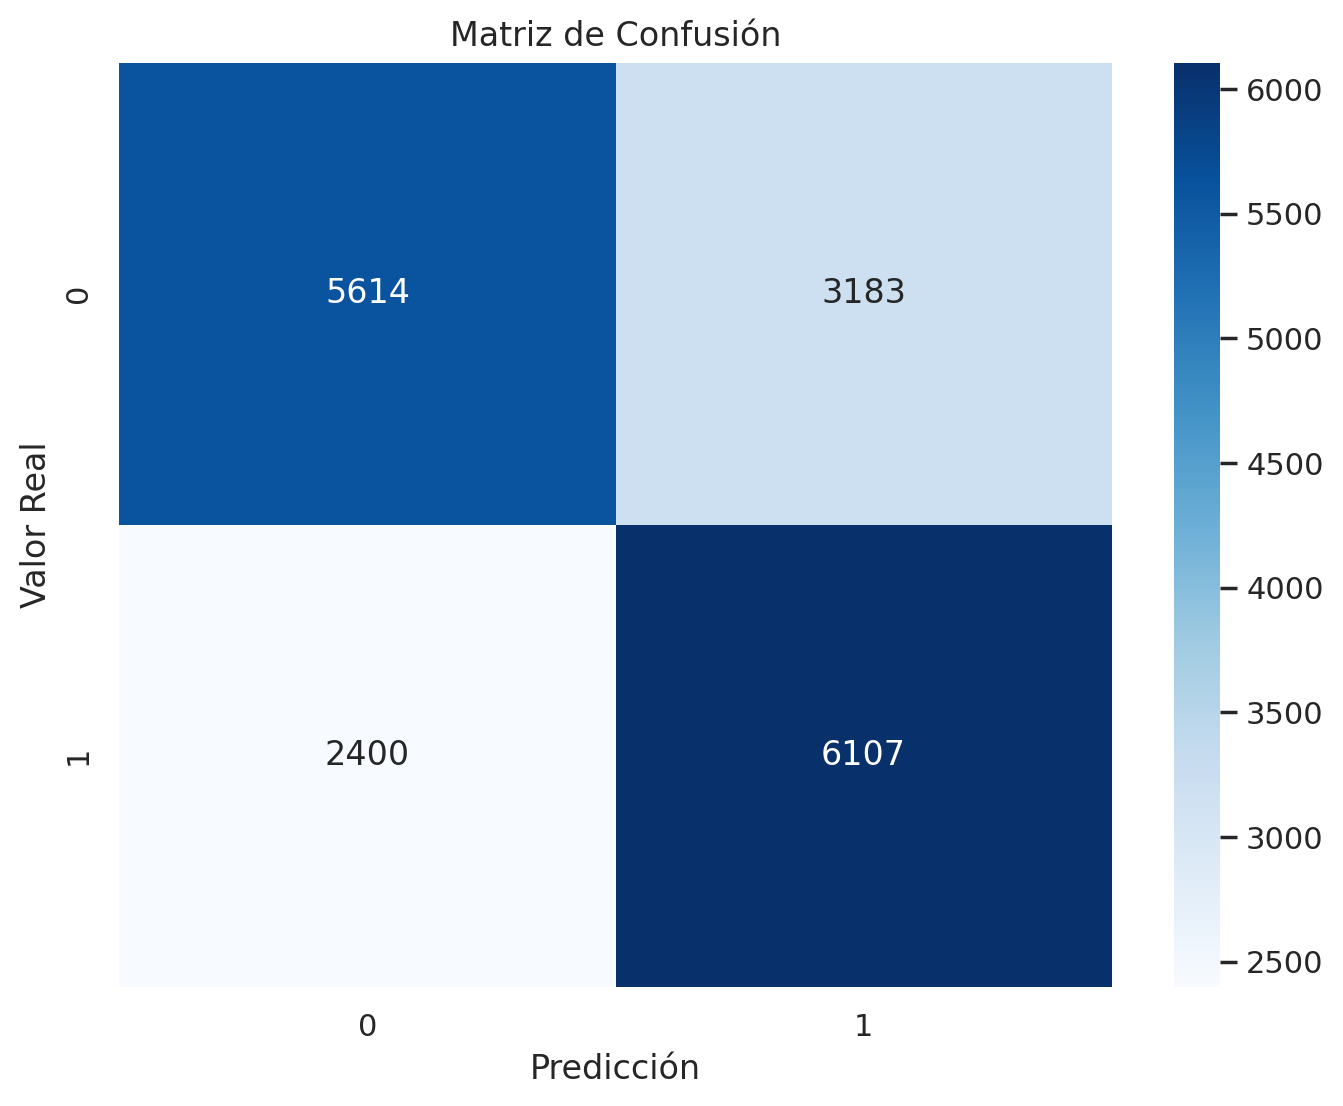

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Mostrar la gráfica
plt.show()

# Guardar el modelo


In [ ]:
import joblib

import os
# Guardar el modelo entrenado
model_folder = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Depresión/LDA/Experimentos pt2'  # Ruta de la carpeta donde deseas guardar el modelo
model_filename = 'TWEETS_depresión_word2vec_RL_LDA.pkl'
model_path = os.path.join(model_folder, model_filename)

# Asegurarse de que la carpeta exista
os.makedirs(model_folder, exist_ok=True)

# Guardar el modelo utilizando joblib
joblib.dump(model, model_path)

# Imprimir la ruta del modelo guardado
print(f"Modelo guardado en: {model_path}")

Modelo guardado en: /content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Depresión/LDA/Experimentos pt2/TWEETS_depresión_word2vec_RL_LDA.pkl
